# Expectation Maximisation for Ridge Regression

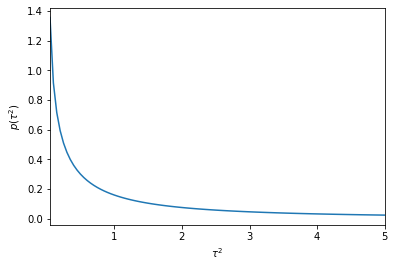

In [1]:
from scipy.stats import betaprime
from matplotlib import pyplot as plt
import numpy as np

_x = np.linspace(0.05, 5, 100)
plt.plot(_x, betaprime.pdf(_x, 0.5, 0.5))
plt.margins(x=0)
plt.xlabel(r'$\tau^2$')
plt.ylabel(r'$p(\tau^2)$')
plt.show()

## Implementation of Ridge EM

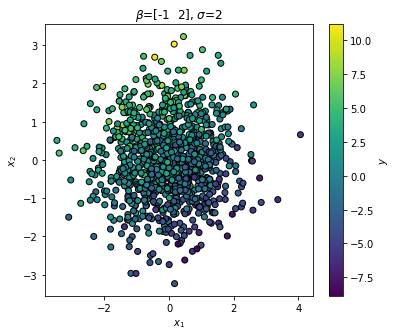

In [4]:
from scipy.stats import norm, multivariate_normal
from experiments import LinearProblem

p1 = LinearProblem(np.array([-1, 2]), 2, multivariate_normal([0, 0]))
x, y = p1.rvs(1000)

plt.figure(figsize=(6, 5))
sc = plt.scatter(x[:, 0], x[:, 1], c=y, edgecolors='black')
plt.colorbar(sc, label='$y$')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title(f'$\\beta$={p1.beta}, $\\sigma$={p1.sigma}')
plt.show()

In [5]:
from sklearn.linear_model import RidgeCV
from fastridge import RidgeEM, RidgeLOOCV

x, y = p1.rvs(1000)
print('RidgeCV')
ridge_cv = RidgeCV(fit_intercept=False, alphas=[10**e for e in range(-4, 5)]).fit(x, y)
print('RidgeLOOCV')
ridge_loocv = RidgeLOOCV(fit_intercept=False, alphas=[10**e for e in range(-4, 5)]).fit(x, y)
print('RidgeEM')
ridge_em = RidgeEM(fit_intercept=False, verbose=1, trace=1).fit(x, y)
print('RidgeEM no normalization')
ridge_em_non_norm = RidgeEM(fit_intercept=False, normalize=False, verbose=1, trace=1).fit(x, y)
print('Ridge EM iterative M-step')
ridge_em_iterative = ridge_em = RidgeEM(fit_intercept=False, closed_form_m_step=False, verbose=1, trace=1).fit(x, y)

RidgeCV
RidgeLOOCV
RidgeEM
0.3558121295925068 0.4394947017323285 [-0.33337253  0.6618714 ]
0.3548447520304065 0.438376985870848 [-0.33280363  0.66069246]
0.35484028951606156 0.4383747719694467 [-0.33280123  0.66068748]
0.35484026801773416 0.4383747676216163 [-0.33280122  0.66068746]
0.35484026791233364 0.4383747676132636 [-0.33280122  0.66068746]
RidgeEM no normalization
0.347976437476991 3.986484328727199 [-0.99308865  1.96821655]
0.3470183511501533 3.976345541601673 [-0.99137248  1.96467959]
0.3470139345971053 3.976325460311595 [-0.99136523  1.96466464]
0.34701391334758047 3.9763254208784273 [-0.99136519  1.96466458]
0.34701391324356023 3.976325420802688 [-0.99136519  1.96466458]
Ridge EM iterative M-step
6961694.080208576 9739821.71061824 [-0.33337253  0.6618714 ]
6961694.080208576 9739821.71061824 [-0.33368758  0.66252438]
6961694.080208576 9739821.71061824 [-0.33368758  0.66252438]


In [233]:
ridge_cv.alpha_, ridge_cv.coef_

(1.0, array([-0.9301027 ,  1.99071223]))

In [234]:
ridge_loocv.alpha_, ridge_loocv.coef_, ridge_loocv.sigma_square_**0.5

(1, array([-0.93007443,  1.99092046]), 2.0498908720279543)

In [236]:
ridge_em_non_norm.coef_, ridge_em_non_norm.intercept_, ridge_em_non_norm.alpha_, ridge_em_non_norm.sigma_square_**0.5

(array([-0.92826427,  1.98623422]), 0.0, 3.042798945543424, 2.0476257483538305)

In [235]:
ridge_em.coef_, ridge_em.intercept_, ridge_em.alpha_, ridge_em.sigma_square_**0.5

(array([-0.93100532,  1.9929117 ]),
 0.0,
 4.1430592799169654e-08,
 18275.67428416344)

## Systematic Comparison

In [120]:
from sklearn.base import clone
from fastprogress.fastprogress import progress_bar 
import time

class ParameterMeanSquaredError:

    @staticmethod
    def __call__(est, prob, x, y):
        return ((est.coef_ - prob.beta)**2).mean()

    @staticmethod
    def __str__():
        return 'parameter_mean_squared_errors'

    @staticmethod
    def symbol():
        return r'$\|\hat{\beta}-\beta\|^2/p$'

class PredictionMeanSquaredError:

    @staticmethod
    def __call__(est, prob, x, y):
        return ((est.predict(x) - y)**2).mean()

    @staticmethod
    def __str__():
        return 'prediction_mean_squared_errors'

    @staticmethod
    def symbol():
        return r'$\|\hat{y}-y\|^2/m$'    

class RegularizationParameter:

    @staticmethod
    def __call__(est, prob, x, y):
        return est.alpha_

    @staticmethod
    def __str__():
        return 'lambda'

    @staticmethod
    def symbol():
        return r'$\lambda$'

class NumberOfIterations:

    @staticmethod
    def __call__(est, prob, x, y):
        if hasattr(est, 'iterations_'):
            return est.iterations_
        elif hasattr(est, 'alphas'):
            return len(est.alphas)
        else:
            return float('nan')

    @staticmethod
    def __str__():
        return 'number_of_iterations'

    @staticmethod
    def symbol():
        return '$k$'

class VarianceAbsoluteError:

    @staticmethod
    def __call__(est, prob, x, y):
        if hasattr(est, 'sigma_square_'):
            return abs(prob.sigma**2 - est.sigma_square_)
        else:
            return float('nan')

    @staticmethod
    def __str__():
        return 'variance_abs_error'

    @staticmethod
    def symbol():
        return r'$|\hat{\sigma}^2-\sigma^2|$'

class FittingTime:

    @staticmethod
    def __call__(est, prob, x, y):
        return est.fitting_time_

    @staticmethod
    def __str__():
        return 'fitting_time'

    @staticmethod
    def symbol():
        return r'$T_\mathrm{fit}$ [s]'

parameter_mean_squared_error = ParameterMeanSquaredError()
prediction_mean_squared_error = PredictionMeanSquaredError()
regularization_parameter = RegularizationParameter()
number_of_iterations = NumberOfIterations()
variance_abs_error = VarianceAbsoluteError()
fitting_time = FittingTime()

default_stats = [parameter_mean_squared_error, prediction_mean_squared_error, regularization_parameter, number_of_iterations, fitting_time]

class Experiment:

    def __init__(self, problems, estimators, ns, reps, est_names=None, stats=default_stats, keep_fits=True, verbose=0):
        self.problems = problems
        self.estimators = estimators
        self.ns = np.atleast_2d(ns)
        self.ns = self.ns if len(self.ns)==len(self.problems) else self.ns.repeat(len(problems), axis=0)
        self.reps = reps
        self.verbose = verbose
        self.est_names = [str(est) for est in estimators] if est_names is None else est_names 
        self.stats = stats
        self.keep_fits = keep_fits
        self.test_size = 10000

    def run(self):
        if self.keep_fits:
            self.fits = {}
        for stat in self.stats:
            self.__dict__[str(stat)+'_'] = np.zeros(shape=(self.reps, len(self.problems), len(self.ns[0]), len(self.estimators)))
        for r in progress_bar(range(self.reps)):
            # if self.verbose:
            #     print('.', end='', flush=True)
            for i in range(len(self.problems)):
                x_test, y_test = self.problems[i].rvs(self.test_size)
                for n_idx, n in enumerate(self.ns[i]):
                    for j, est in enumerate(self.estimators):
                        x, y = self.problems[i].rvs(n)
                        _est = clone(est, safe=False)
                        fit_start_time = time.time()
                        _est.fit(x, y)
                        _est.fitting_time_ = time.time() - fit_start_time
                        if self.keep_fits:
                            self.fits[(r, i, n, j)] = _est
                        for stat in self.stats:
                            self.__dict__[str(stat)+'_'][r, i, n_idx, j] = stat(_est, self.problems[i], x_test, y_test)
        # if self.verbose:
        #     print()
        return self


In [12]:
import experiments
from importlib import reload
reload(experiments)
from sklearn.linear_model import RidgeCV
from experiments import Experiment, default_stats, variance_abs_error

estimators = [
              RidgeCV(fit_intercept=False, alphas=[10**e for e in np.linspace(-10, 10, 21, endpoint=True)]),
              RidgeLOOCV(fit_intercept=False, alphas=[10**e for e in np.linspace(-10, 10, 21, endpoint=True)]),
            #   RidgeCV(fit_intercept=False, alphas=[10**e for e in np.linspace(-10, 10, 11, endpoint=True)]),
              RidgeEM(fit_intercept=False),
              RidgeEM(fit_intercept=False, normalize=False)
              ]
# est_names = ['CV_101', 'CV_11', 'EM', 'EM_raw']
est_names = ['CV_21', 'LOOCV_21', 'EM', 'EM_raw']
ns = [10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 200, 400, 800]
exp = Experiment([p1], estimators, ns, 1000, est_names=est_names, stats=default_stats+[variance_abs_error], verbose=True)
exp.run()


/usr/local/lib/python3.9/site-packages/matplotlib/axes/_base.py:2480: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


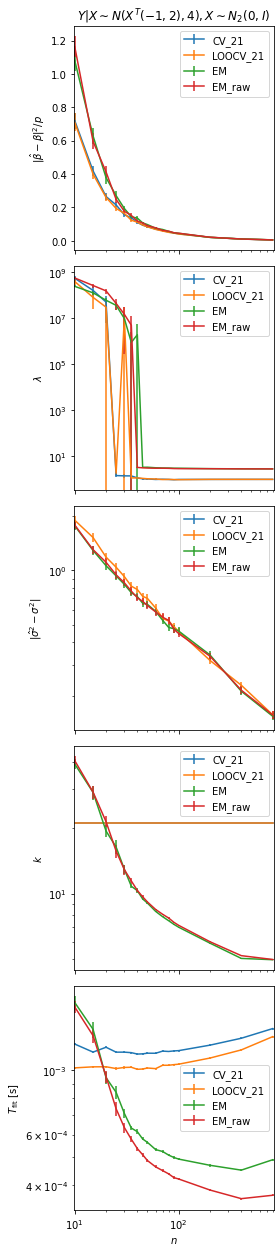

In [17]:
from plotting import plot_metrics
from experiments import parameter_mean_squared_error, regularization_parameter, number_of_iterations, fitting_time

fig, axs = plot_metrics([parameter_mean_squared_error, regularization_parameter, variance_abs_error, number_of_iterations, fitting_time], exp)
axs[0, 0].set_xscale('log')
axs[1, 0].set_yscale('log')
axs[2, 0].set_yscale('log')
axs[3, 0].set_yscale('log')
axs[4, 0].set_yscale('log')
axs[0, 0].set_title(r'$Y|X \sim N(X^T(-1, 2), 4), X\sim N_2(0, I)$')
plt.show()

In [18]:
# p2 = problem(np.array([-1, 200, 1, -10, 0, 0]), 4.0, multivariate_normal([0, 0, 0, 0, 0, 0]))
ps = [LinearProblem(np.array([-1, 200, 1, -10, 0, 0]), sigma, multivariate_normal([0, 0, 0, 0, 0, 0])) for sigma in [1.0, 2.0, 3.0, 4.0]]
# estimators = [RidgeCV(fit_intercept=False, alphas=[0.001, 0.01, 0.1, 1, 10, 100]), RidgeEM()]
# est_names = ['CV', 'EM']

estimators = [
              RidgeCV(fit_intercept=False, alphas=[10**e for e in np.linspace(-5, 5, 11, endpoint=True)]),
              RidgeCV(fit_intercept=False, alphas=[10**e for e in np.linspace(-10, 10, 21, endpoint=True)]),
              RidgeCV(fit_intercept=False, alphas=[10**e for e in np.linspace(-10, 10, 101, endpoint=True)]),
            # RidgeLOOCV(fit_intercept=False, alphas=[10**e for e in np.linspace(-10, 10, 21, endpoint=True)]),
              RidgeCV(fit_intercept=False, alphas=[10**e for e in np.linspace(-11, 11, 23, endpoint=True)]),
              RidgeEM(fit_intercept=False)
              # RidgeEM(fit_intercept=False, normalize=False)
              ]
# est_names = ['CV_101', 'CV_11', 'EM', 'EM_raw']
est_names = ['LOOCV_11_5', 'LOOCV_21_10', 'LOOCV_101_10', 'LOOCV_23_11', 'EM']
ns = [10, 20, 40, 80, 160, 320, 640, 1280]
exp2 = Experiment(ps, estimators, ns, 100, est_names=est_names, verbose=True)
exp2.run()


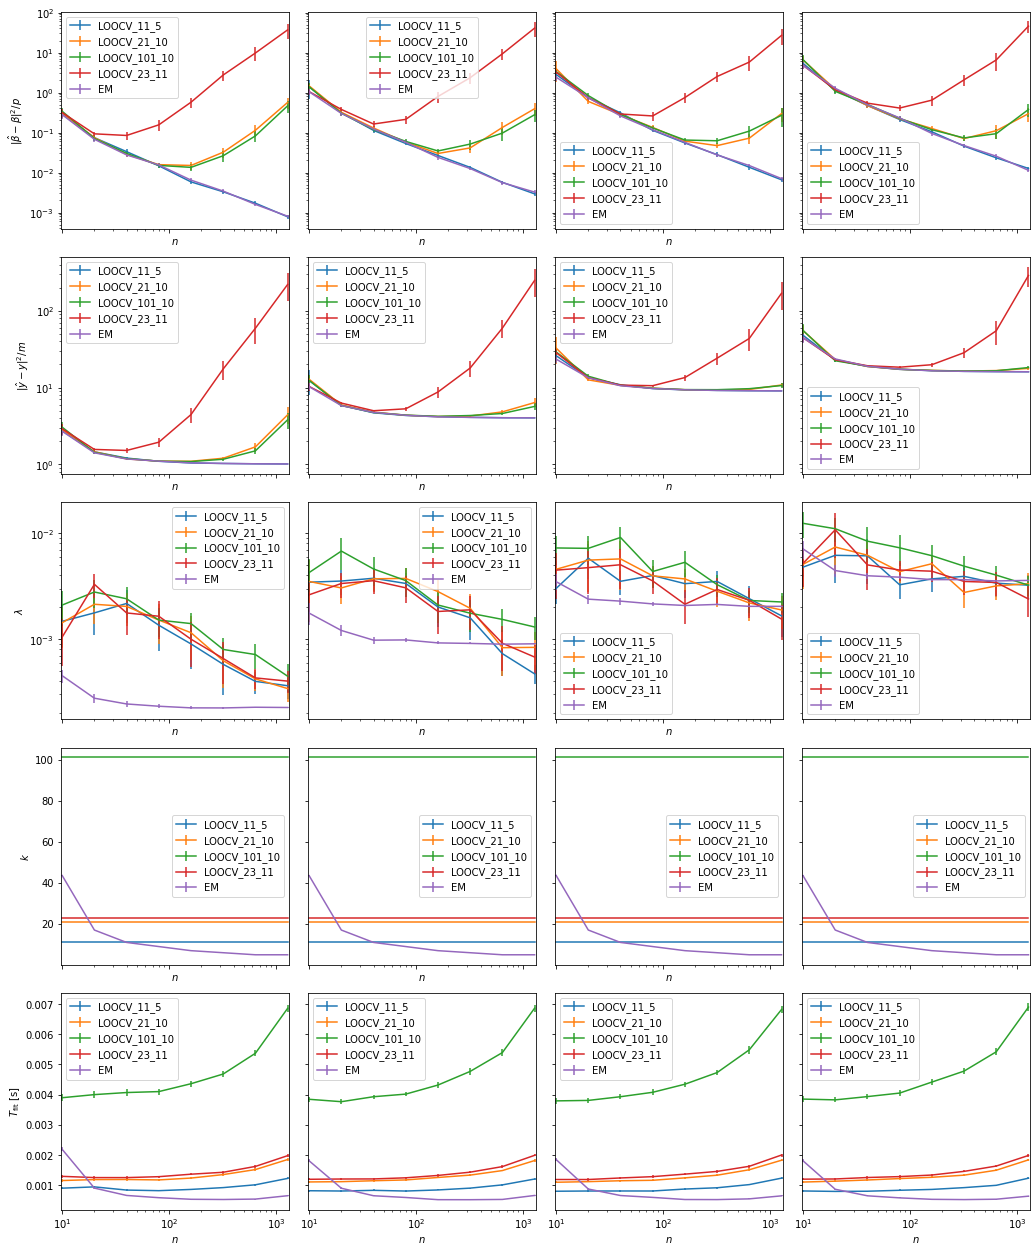

In [19]:
fig, axs = plot_metrics(default_stats, exp2, est_idx=[0, 1, 2, 3, 4])
# axs[3, 0].set_yscale('log')
axs[3, 0].set_xscale('log')
axs[0, 0].set_yscale('log')
axs[1, 0].set_yscale('log')
axs[2, 0].set_yscale('log')
plt.show()

## Sparse Design Matrices

In [505]:
class eye_covariates:

    def __init__(self, p):
        self.p = p

    def rvs(self, n):
        I = np.eye(self.p)
        rnd_idx = np.random.choice(self.p, size=n%self.p)
        np.row_stack((n//self.p*(I,)+(I[rnd_idx],)))

In [323]:
from scipy.stats import uniform

class multivariate_bernoulli:

    def __init__(self, probs):
        self.probs = probs

    def rvs(self, size=1):
        res = uniform.rvs(size=(size, len(self.probs)))
        return (res <= self.probs).astype(float)

dist = multivariate_bernoulli(np.array([0.2, 0.2, 0.2, 0.2, 0.2]))
dist.rvs(10)

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 1., 0., 1., 0.]])

In [581]:
class eye_covariates:

    def __init__(self, p):
        self.p = p

    def rvs(self, size=1):
        I = np.eye(self.p)
        rnd_idx = np.random.choice(self.p, size=size%self.p)
        return np.row_stack((size//self.p*(I,)+(I[rnd_idx],)))

eye_covariates(5).rvs(12)

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [89]:
from numpy.random import choice
from scipy.stats import wishart

def random_sparse_vector(p, r, std=1):
    beta_ = multivariate_normal.rvs(np.zeros(r), np.diag(r*[std]))
    idx = choice(p, r)
    beta = np.zeros(p)
    beta[idx] = beta_
    return beta

def random_sparse_factor_problem(p=100, r=None, sigma=0.5):
    r = p if r is None else r
    x_dist = multivariate_bernoulli(np.array([1/p]*p))
    beta = random_sparse_vector(p, r)
    return problem(beta, sigma, x_dist)

def random_multiple_means_problem(p=100, r=None, sigma=0.5):
    r = p if r is None else r
    x_dist = eye_covariates(p)
    beta = random_sparse_vector(p, r)
    return problem(beta, sigma, x_dist)    

def random_problem(p, r):
    x_cov = wishart.rvs(p, np.eye(p))
    x_mu = multivariate_normal.rvs(np.zeros(p))
    x_dist = multivariate_normal(x_mu, x_cov)
    beta = random_problem(p, r)    
    return problem(beta, 0.5, x_dist)

In [92]:
random_sparse_vector(10, 10)

array([ 0.        ,  0.        ,  0.        , -1.00054071,  0.28902825,
       -0.0191294 ,  0.        ,  0.        , -0.32527142,  0.01708895])

In [96]:
shu_problem = problem(np.array([-8.5138504, 0.1730799, 16.2624631, -10.0661790, -7.0062500]), 5, multivariate_normal(np.zeros(5)))
shu_problem.rvs(10)

shu_experiments = Experiment([shu_problem], estimators, [100, 200, 300, 400, 500], 10, est_names).run()

In [104]:
shu_experiments.fits[(9, 0, 200, 1)].sigma_square_

23.744121233217488

In [467]:
p3 = random_sparse_factor_problem(100)
x, y = p3.rvs(10)
x.sum(axis=1), x.shape

(array([2., 0., 0., 1., 1., 1., 1., 1., 2., 1.]), (10, 100))

In [469]:
exp3 = Experiment([p3], [RidgeCV(fit_intercept=False), RidgeEM()], ns=[80, 160, 320, 640], reps=400)
exp3.run()

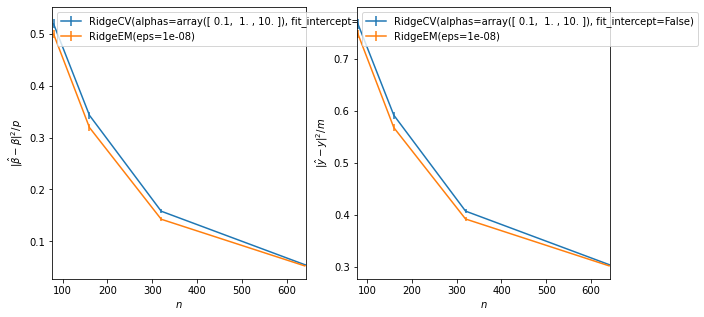

In [472]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plot_metric(parameter_mean_squared_error, exp3, ax=axs[0])
plot_metric(prediction_mean_squared_error, exp3, ax=axs[1])
# plt.xlim(160, 320)
# plt.ylim(0.0, 10000)

In [623]:
ps = np.array([100, 200, 300, 400, 500])
probs = [random_sparse_factor_problem(p) for p in ps]
# ns = np.array(ps).reshape(-1, 1)
ns = np.column_stack([i*ps for i in [1, 2, 3, 4]])
estimators = [RidgeCV(fit_intercept=False, alphas=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0]), RidgeEM()]
estimator_names = ['CV', 'EM']
exp4 = Experiment(probs, estimators, ns, 100, estimator_names, verbose=True)
exp4.run()

....................................................................................................


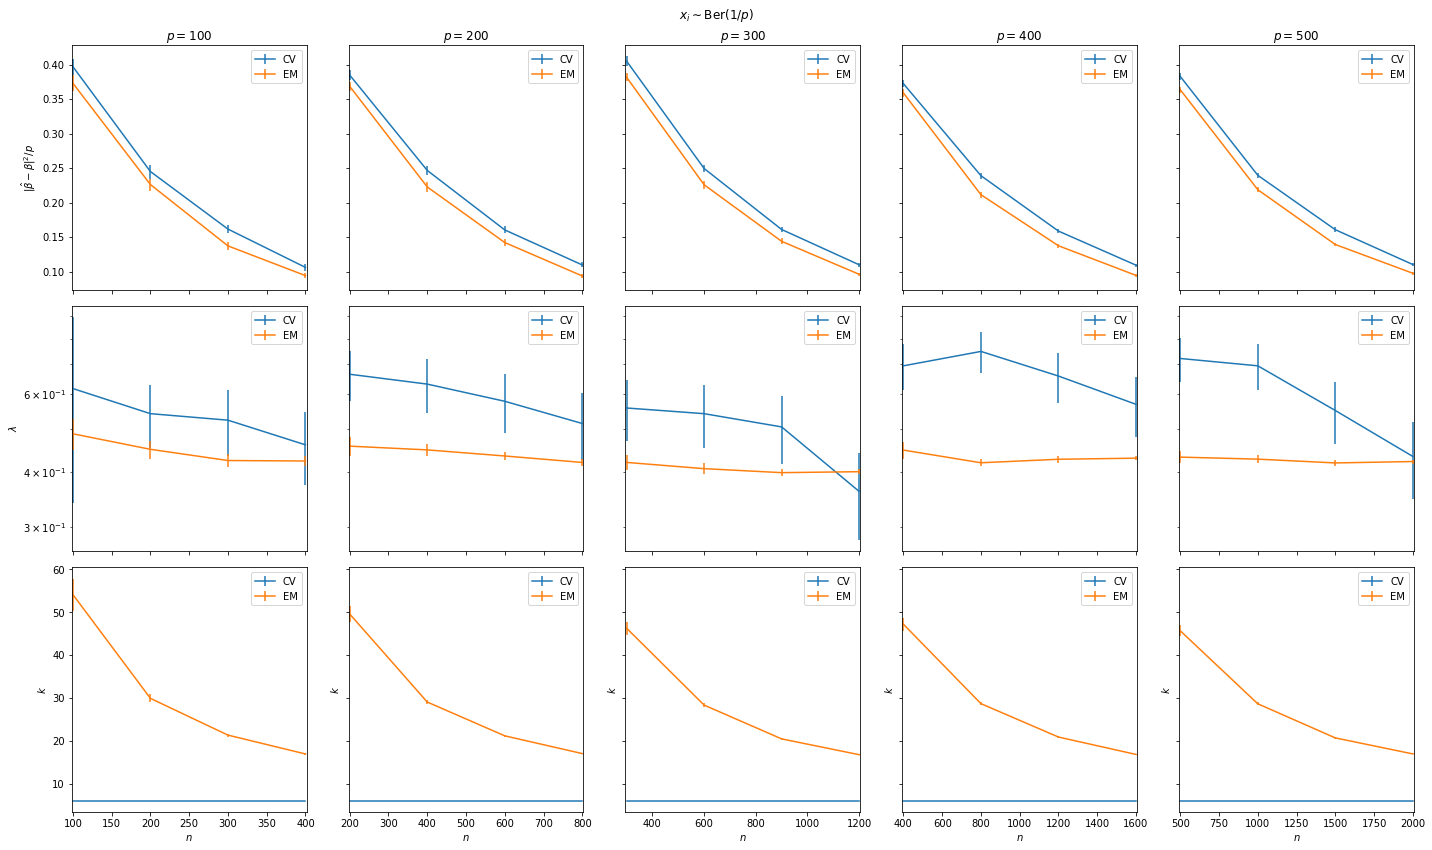

In [631]:
fig, axs = plt.subplots(3, 5, sharey='row', sharex='col', figsize=(20, 12), tight_layout=True)
for p in range(5):
    plot_metric(parameter_mean_squared_error, exp4, p=p, ax=axs[0, p])
    plot_metric(regularization_parameter, exp4, p=p, ax=axs[1, p])
    plot_metric(number_of_iterations, exp4, p=p, ax=axs[2, p])
    axs[0, p].set_title(f'$p={ps[p]}$')
    axs[0, p].set_xlabel(None)
    axs[1, p].set_xlabel(None)
    axs[1, p].set_yscale('log')
    plt.suptitle(r'$x_i \sim \mathrm{Ber}(1/p)$')
    if p>0:
        axs[0, p].set_ylabel(None)
        axs[1, p].set_ylabel(None)

In [657]:
ps = np.array([100, 200, 300, 400, 500])
probs = [random_multiple_means_problem(p) for p in ps]
# ns = np.array(ps).reshape(-1, 1)
ns = np.column_stack([i*ps for i in [1, 2, 3]])
estimators = [RidgeCV(fit_intercept=True), RidgeEM()]
estimator_names = ['CV', 'EM']
exp5 = Experiment(probs, estimators, ns, 100, estimator_names, verbose=True)
exp5.run()

....................................................................................................


Text(0.5, 0.98, 'multiple means')

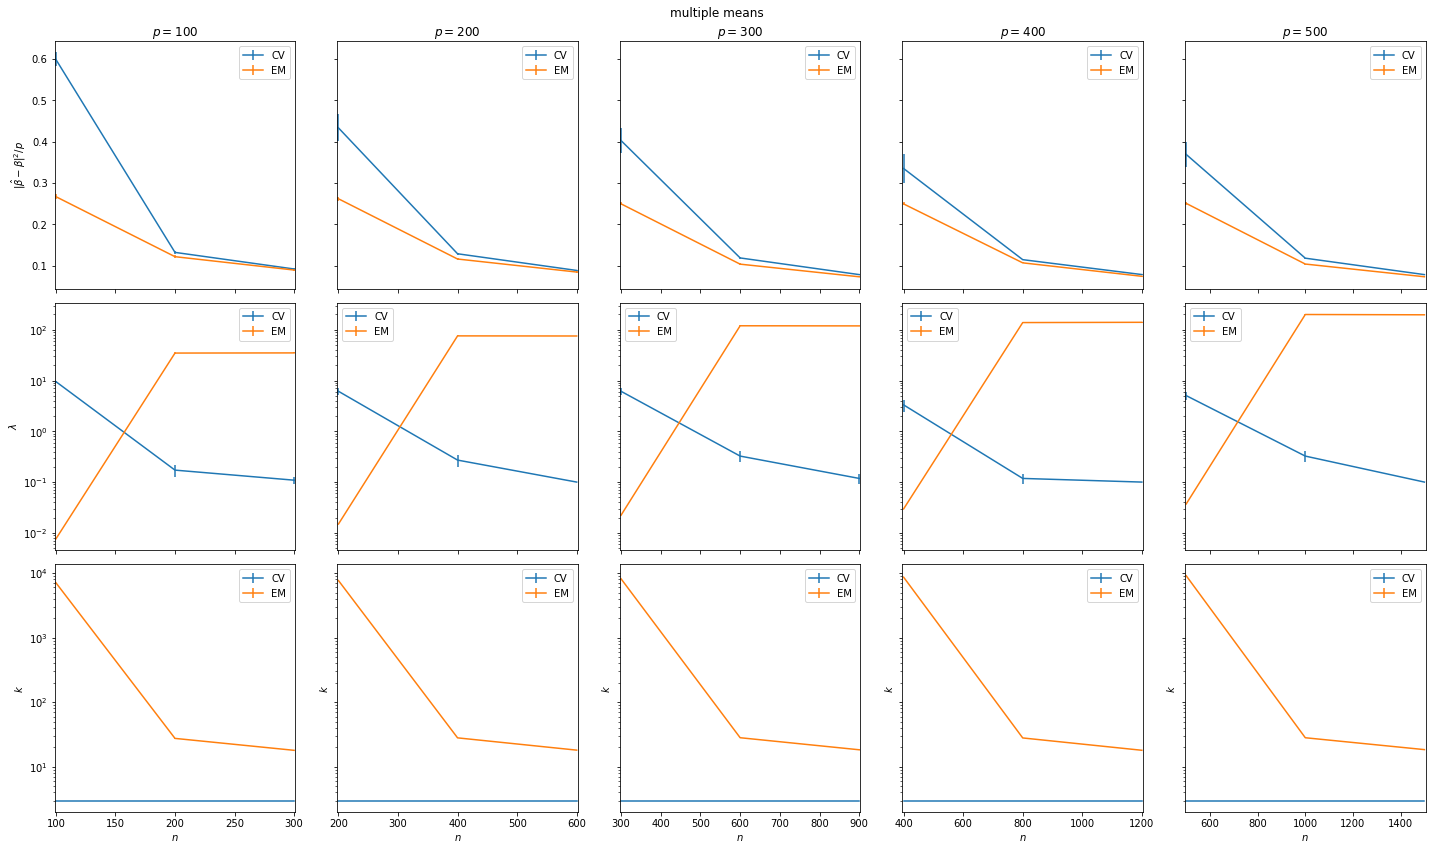

In [658]:
fig, axs = plt.subplots(3, 5, sharey='row', sharex='col', figsize=(20, 12), tight_layout=True)
for p in range(5):
    plot_metric(parameter_mean_squared_error, exp5, p=p, ax=axs[0, p])
    plot_metric(regularization_parameter, exp5, p=p, ax=axs[1, p])
    plot_metric(number_of_iterations, exp5, p=p, ax=axs[2, p])
    axs[0, p].set_title(f'$p={ps[p]}$')
    axs[0, p].set_xlabel(None)
    axs[1, p].set_xlabel(None)
    axs[1, p].set_yscale('log')
    axs[2, p].set_yscale('log')
    if p>0:
        axs[0, p].set_ylabel(None)
        axs[1, p].set_ylabel(None)
plt.suptitle('multiple means')

Text(0.5, 0.98, 'multiple means')

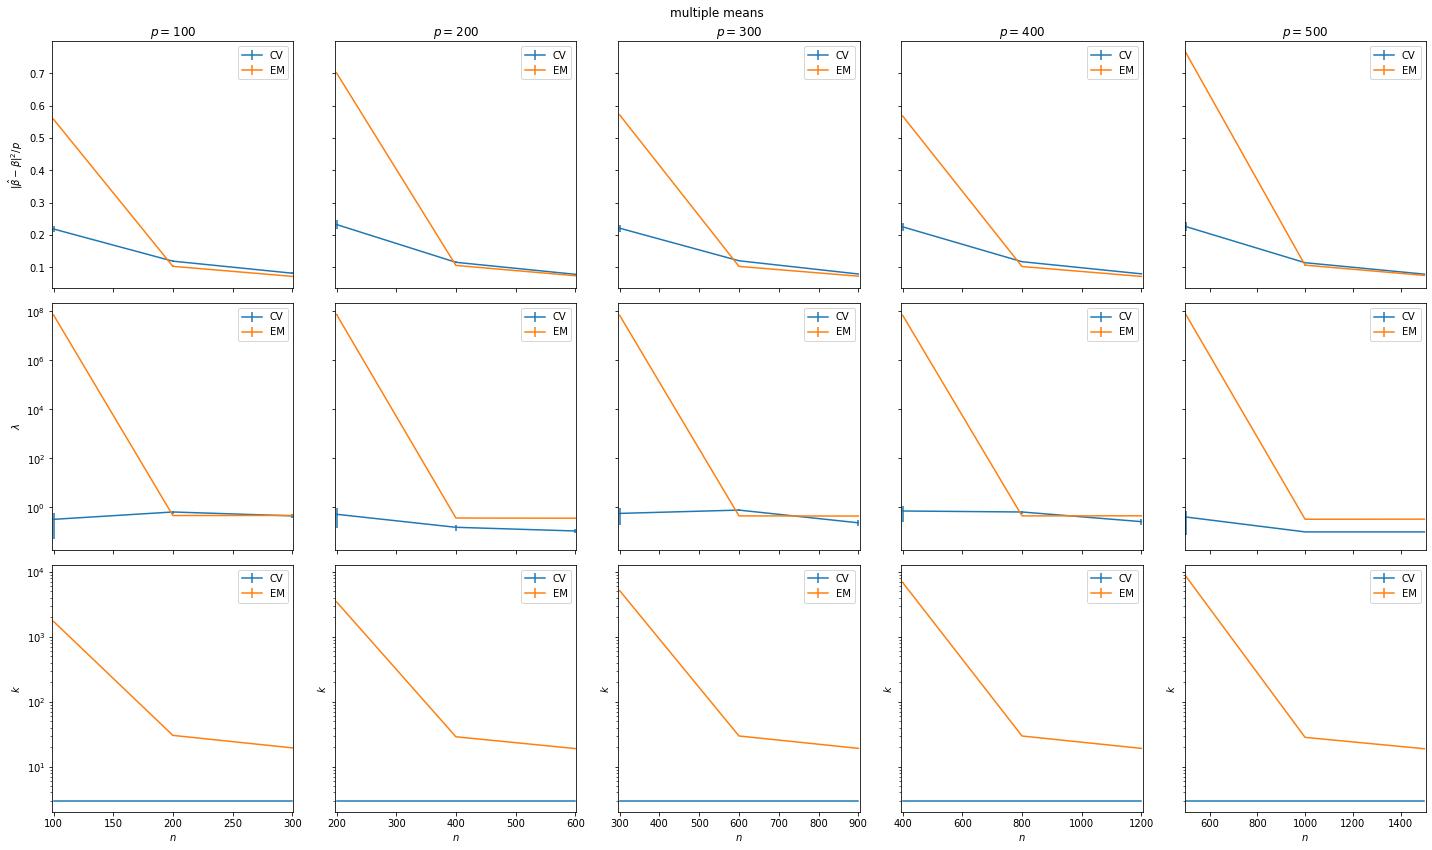

In [645]:
fig, axs = plt.subplots(3, 5, sharey='row', sharex='col', figsize=(20, 12), tight_layout=True)
for p in range(5):
    plot_metric(parameter_mean_squared_error, exp5, p=p, ax=axs[0, p])
    plot_metric(regularization_parameter, exp5, p=p, ax=axs[1, p])
    plot_metric(number_of_iterations, exp5, p=p, ax=axs[2, p])
    axs[0, p].set_title(f'$p={ps[p]}$')
    axs[0, p].set_xlabel(None)
    axs[1, p].set_xlabel(None)
    axs[1, p].set_yscale('log')
    axs[2, p].set_yscale('log')
    if p>0:
        axs[0, p].set_ylabel(None)
        axs[1, p].set_ylabel(None)
plt.suptitle('multiple means')

In [477]:

exp4.parameter_mean_squared_errors_[:, [0, 1, 2, 3, 4], [0, 1, 2, 3, 4], 0].mean(axis=0)

array([0.42330838, 0.28342379, 0.22034077, 0.16913496, 0.16291275])

In [478]:
exp4.parameter_mean_squared_errors_[:, [0, 1, 2, 3, 4], [0, 1, 2, 3, 4], 1].mean(axis=0)

array([0.41330031, 0.27780751, 0.21388841, 0.16563211, 0.16199287])

In [101]:
prob=random_problem(10, 5)
prob.rvs(10)

(array([[ 2.01114659,  1.79940924, -1.58416964, -4.03702343,  1.2625394 ,
          0.62241447, -7.78230803, -2.24935265, -4.16915548, -3.09466615],
        [-0.50962317, -0.04695801, -5.60705681, -1.87769065,  0.31973884,
         -3.93036744, -3.15668954,  0.04294686, -3.74004428, -0.97573737],
        [-0.66485301,  1.39404772,  0.79653707, -4.20896774,  0.73771582,
          5.62381484, -2.66451915,  3.11071595,  5.0492413 ,  3.52982066],
        [-5.82578788, -0.28569489,  1.57273856,  1.69780105,  1.40485322,
         -0.9895052 ,  0.78398869,  3.77124022,  5.77173842,  0.28899546],
        [-3.58013408,  2.6781984 ,  3.28347068, -1.63625558, -0.57343152,
          4.10034531, -1.87398477, -0.65494249, -0.64192925, -1.66413183],
        [ 5.70054442,  2.82972765,  1.65647515, -1.54197925, -0.27251719,
          1.74450953, -6.13521761,  2.76687884, -3.21328719, -1.6981624 ],
        [-4.18678097, -3.34074789,  0.72163048, -0.1029032 ,  0.72918436,
         -5.51574889,  3.7244442

In [102]:
prob.beta

array([ 0.        ,  0.76370138, -0.62879645, -0.04019937, -0.51750536,
        0.        ,  0.        ,  0.        , -1.69206346,  0.        ])

In [110]:
RidgeRegressorEM().fit(*prob.rvs(200))

7.379290830172025e-09 73.79290830172025 [ 1.01668178e-05  1.47900854e-05 -1.55434180e-05 -1.42228151e-06
 -1.21070129e-05  6.18168748e-06 -2.16924356e-05 -9.66547756e-07
 -3.30936946e-05  6.53002854e-06]
5.280396928476955
1.9005051452761904e-05 0.21522948104169565 [ 0.02321015  0.03467925 -0.03676617 -0.00343941 -0.03080993  0.01435565
 -0.04789512 -0.00219285 -0.07962413  0.0147111 ]
0.20153486838968343
0.00017525909497888967 1.7319127104207068 [ 0.10527305  0.19285468 -0.20877611 -0.01950488 -0.22755364  0.06975302
 -0.1872489  -0.01221091 -0.49603308  0.06200013]
0.5034973715723157
0.0171632052501298 79.13513590605027 [ 0.00210903  0.64188361 -0.60100963 -0.02095635 -0.55133554  0.04635796
 -0.04886818  0.0195898  -1.6522904   0.00266118]
0.5795319119774562
218.12901701431667 10220.385263345102 [-0.00619456  0.72288056 -0.63697765 -0.03898877 -0.52422239  0.03025053
 -0.00694939  0.01473285 -1.69499653 -0.01044257]
0.04475929194132568
38732.51562740747 1548473.2364826128 [-0.0061771

In [78]:
a = np.zeros(10)
a

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [76]:
x_dist = random_problem(2, 3)
x_dist.rvs(10)

array([[ 0.61549392,  0.81381207],
       [ 0.87543481,  0.13010523],
       [ 0.43339256,  2.23997696],
       [ 0.61083068,  0.54145492],
       [ 0.80624568, -0.04247553],
       [ 0.59792307,  0.84333561],
       [ 0.52932307,  1.59920209],
       [ 0.56145016,  0.93877732],
       [ 0.55263419,  1.04173214],
       [ 0.80729819,  0.11900885]])

In [26]:
from scipy.linalg import svd

u, s, v = svd(x)

In [130]:
ridgeEM.coefs_, ridgeEM.tau_squares_, ridgeEM.sigma_squares_

([array([-0.00014227,  0.00030809]),
  array([-0.96676597,  1.94529433]),
  array([-0.99725937,  2.00284359]),
  array([-0.9972632 ,  2.00285082]),
  array([-0.99726321,  2.00285083])],
 [1.6669796268463134e-07,
  0.03670264822210466,
  300.2963919163981,
  121803.93132689614,
  48575412.22873576],
 [1666.9796268463135,
  175.37014124241196,
  69051.78390424214,
  27538845.525937952,
  10982492591.448257])